In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from glob import glob
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

import utils.constants as constants
# from src.data import PhenoInfo
from utils.utils import chunker

In [3]:
genes_associations_dir = os.path.join(constants.PREPROCESSED_BASED_DIR, 'gene_associations')
smultixcan_gene_association_dirs = os.path.join(genes_associations_dir, 'mashr')

# Load metadata

In [4]:
with open(os.path.join(constants.PREPROCESSED_METADATA_DIR, 'genes_mapping_simplified-0.pkl'), 'rb') as f:
    genes_mapping_0 = pickle.load(f)

with open(os.path.join(constants.PREPROCESSED_METADATA_DIR, 'genes_mapping_simplified-1.pkl'), 'rb') as f:
    genes_mapping_1 = pickle.load(f)

# Load pheno info

In [5]:
phenos_info = pd.read_csv(os.path.join(constants.DATA_DIR, 'phenotypes.both_sexes.tsv.gz'), sep='\t')
phenos_info = phenos_info.dropna(subset=['description'])

In [6]:
phenos_info.head(3)

,phenotype,description,variable_type,source,n_non_missing,n_missing,n_controls,n_cases,PHESANT_transformation,notes
0,G54,Diagnoses - main ICD10: G54 Nerve root and ple...,categorical,icd10,361194,0,361051.0,143.0,NaN,NaN
1,C21,Diagnoses - main ICD10: C21 Malignant neoplasm...,categorical,icd10,361194,0,361055.0,139.0,NaN,NaN
2,F45,Diagnoses - main ICD10: F45 Somatoform disorders,categorical,icd10,361194,0,360953.0,241.0,NaN,NaN


# Functions to get gene bands

In [7]:
biomart_genes = pd.read_csv('/mnt/phenomexcan/data/biomart_genes_hg38.csv', index_col='ensembl_gene_id')

In [8]:
biomart_genes.head()

,Unnamed: 0,external_gene_name,chromosome_name,start_position,end_position,band,gene_biotype
ensembl_gene_id,,,,,,,
ENSG00000262477,1,AC021224.1,18,32412182,32413236,q12.1,lincRNA
ENSG00000212378,2,RF00592,2,72760534,72760602,p13.2,snoRNA
ENSG00000277234,3,RNU1-5P,1,16873708,16873851,p36.13,snRNA
ENSG00000243313,4,RN7SL285P,6,37832922,37833185,p21.2,misc_RNA
ENSG00000251915,5,RNA5SP406,16,35734393,35734504,p11.1,rRNA_pseudogene


In [9]:
def get_gene_band(gene_name):
    gene_data = biomart_genes.loc[genes_mapping_1[gene_name]]
    chrom = gene_data['chromosome_name']
    band = biomart_genes.loc[genes_mapping_1[gene_name], 'band']
    return f'{chrom}{band}'

In [10]:
get_gene_band('RASIP1')

'19q13.33'

# Clustermap as a matrix

In [23]:
# load again to check that the file just save is readable
clustermap_matrix = pd.read_csv('/mnt/tmp/clustermap.tsv.gz', sep='\t', index_col='ukb')

In [24]:
clustermap_matrix.shape

(1932, 4377)

In [25]:
clustermap_matrix.head()

,"Symphalangism, proximal, 1b","Brachydactyly, type a1, c",Acromesomelic dysplasia Hunter Thompson type,Type C brachydactyly,Fibular hypoplasia and complex brachydactyly,Multiple synostoses syndrome 2,Osteoarthritis of hip,Grebe syndrome,Atypical hemolytic-uremic syndrome 4,Complement factor B deficiency,...,Hereditary sensory neuropathy type IE,"Cerebellar ataxia, deafness, and narcolepsy, autosomal dominant",Shprintzen-Goldberg syndrome,"Growth and mental retardation, mandibulofacial dysostosis, microcephaly, and cleft palate",Alexander Disease,Wilms tumor 6,"FIBROMATOSIS, GINGIVAL, 5",Witteveen-kolk syndrome,Retinitis pigmentosa 59,DEVELOPMENTAL DELAY AND SEIZURES WITH OR WITHOUT MOVEMENT ABNORMALITIES
ukb,,,,,,,,,,,,,,,,,,,,,
1747_2-Hair_colour_natural_before_greying_Red,5.196536,5.196536,5.196536,5.196536,5.196536,5.196536,5.196536,5.196536,0.681979,0.681979,...,1.393441,1.393441,1.175068,0.912711,0.984230,0.964754,0.964754,1.046317,1.361394,1.361394
1747_4-Hair_colour_natural_before_greying_Dark_brown,5.204768,5.204768,5.204768,5.204768,5.204768,5.204768,5.204768,5.204768,0.843744,0.843744,...,0.282591,0.282591,1.055308,1.532659,0.995257,1.547422,1.547422,1.314258,1.552237,1.552237
1727-Ease_of_skin_tanning,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,1.707434,1.707434,...,1.535866,1.535866,0.981077,1.263048,0.902915,1.634127,1.634127,0.841346,0.925896,0.925896
1717-Skin_colour,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,6.324555,1.249305,1.249305,...,1.624039,1.624039,1.013704,0.734270,1.300681,1.695211,1.695211,0.909564,1.438901,1.438901
30100_raw-Mean_platelet_thrombocyte_volume,2.175192,2.175192,2.175192,2.175192,2.175192,2.175192,2.175192,2.175192,4.058183,4.058183,...,0.264170,0.264170,2.309409,2.538910,2.530703,3.117539,3.117539,2.792532,1.444716,1.444716


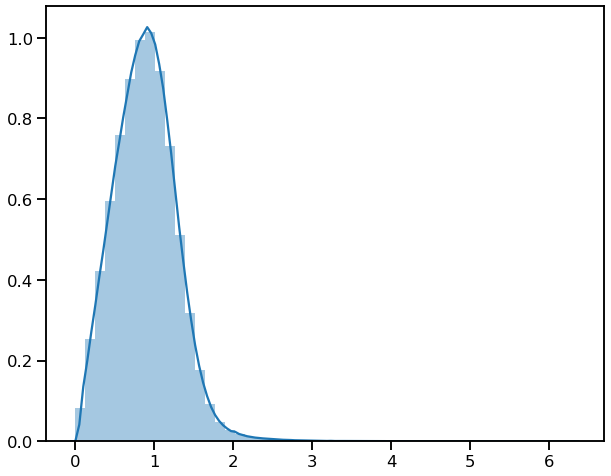

In [28]:
# plot z-score density
flat_values = clustermap_matrix.values.flatten()
flat_values = pd.Series(flat_values)

plt.figure(figsize=(10, 8))
with sns.plotting_context(context='talk'):
    sns.distplot(flat_values)

In [29]:
flat_values.describe().apply(lambda x: '%.3f' % x)

count    8456364.000
mean           0.890
std            0.397
min            0.001
25%            0.612
50%            0.879
75%            1.138
max            6.325
dtype: object

### Plot

In [14]:
selected_matrix = clustermap_matrix.iloc[:300, :300]

In [15]:
t = np.array(selected_matrix.shape)
display(f'Data size: {t}')
fig_size = list(reversed(tuple((t / max(t)) * 200)))
display(fig_size)

'Data size: [300 300]'

[200.0, 200.0]

In [31]:
plt.figure(figsize=fig_size)
ax = sns.heatmap(data=selected_matrix, yticklabels=False, xticklabels=False, cmap='Blues')

#plt.savefig('/mnt/tmp/clustermap.pdf', bbox_inches='tight')
plt.savefig('/mnt/tmp/phenomexcan_heatmap.png', dpi=150, bbox_inches='tight')

#### Examples of submatrices finding

In [33]:
from clustering.biclustering.analysis import Trait

In [38]:
selected_matrix = clustermap_matrix.iloc[102:147, 150:200]

In [39]:
selected_matrix = selected_matrix.rename(index={t:Trait(t).get_pretty_name() for t in selected_matrix.index})

In [40]:
with sns.plotting_context('poster', font_scale=3.00):
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(data=selected_matrix, yticklabels=True, xticklabels=False)

## Other queries and analysis

In [ ]:
def _get_conds(trait_query, traits):
    traits = traits.str.lower()
    x2_conds = [np.array(traits.str.contains(sub_trait.lower())) for sub_trait in trait_query.split('|')]
    
    x2_cond = x2_conds[0]
    for x2_c in x2_conds[1:]:
        x2_cond = np.bitwise_and(x2_cond, x2_c)
    
    return x2_cond

def search_phenotypes(ukb_trait, clinvar_trait, ukb_idx=0, clinvar_idx=0, radius=5):
    x1_cond = _get_conds(ukb_trait, clustermap_matrix.index)
    x1_idx = np.where(x1_cond)[0][ukb_idx]
    
    x2_cond = _get_conds(clinvar_trait, clustermap_matrix.columns)
    x2_idx = np.where(x2_cond)[0][clinvar_idx]
    
    x1_low = np.max((0, x1_idx - radius))
    x1_high = np.min((clustermap_matrix.shape[0] - 1, x1_idx + radius))
    
    x2_low = np.max((0, x2_idx - radius))
    x2_high = np.min((clustermap_matrix.shape[1] - 1, x2_idx + radius))
    
    return (
        (clustermap_matrix.index[x1_idx], clustermap_matrix.columns[x2_idx]),
        (clustermap_matrix.index[x1_low:x1_high], clustermap_matrix.columns[x2_low:x2_high])
    )

def show_shared_genes(ukb_trait, clinvar_trait):
    x1 = spredixcan_genes_associations[ukb_trait].rename(index=genes_mapping_0)
    
    x2 = clinvar_genes_associations[clinvar_trait]
    x2_genes = x2[x2 > 0].index
    shared_genes = x1.index.intersection(x2_genes)
    
    if len(shared_genes) != len(x1.index):
        print('WARNING: genes not found: {}'.format(', '.join([x for x in x2_genes if x not in x1.index])))
    
    df = x1.loc[shared_genes].to_frame('zscore')
    df = df.assign(band=df.apply(lambda x: get_gene_band(x.name), axis=1)).set_index('band', append=True)
    return df

## Height with muscular dystrophy

In [ ]:
# example of slicing where
with sns.plotting_context('talk', font_scale=1.0):
    plt.figure(figsize=(15, 15))
    sns.heatmap(clustermap_matrix.iloc[:10, :10], yticklabels=True, xticklabels=True, cmap='Blues')
#    plt.savefig('/mnt/tmp/sample_heatmap.pdf')

## Agnostic survey

Biclusters found:

- Blood phenotypes (mean corpuscular volume, corpuscular haemoglobin, etc) with **Parkinson disease**
- Blood phenotypes with **spherocytosis**
- White blood cells (leukocytes and neutrophils) with **hyperphosphatasia with mental retardation**
* Skin and hair color

In [ ]:
with sns.plotting_context('talk', font_scale=0.6):
    plt.figure(figsize=(15, 15))
    sns.heatmap(clustermap_matrix.iloc[0:75, 83:135], yticklabels=True, xticklabels=True, cmap='Blues')
#    plt.savefig('/mnt/tmp/sample_heatmap.pdf')

### Parkinson 15

In [ ]:
phenos = search_phenotypes('30040_raw-', 'Parkinson|15')

In [ ]:
phenos

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[0][1]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

### Spherocytosis

In [ ]:
phenos = search_phenotypes('30000_raw-', 'Spherocytosis')

In [ ]:
phenos

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[0][1]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

### Skin/hair color

In [ ]:
phenos = search_phenotypes('1717-', 'Glutha')

In [ ]:
phenos

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[0][1]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[1][1][0]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[1][1][7]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[1][1][8]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

# Focus on a particular disease

## Asthma

In [ ]:
phenos = search_phenotypes('asthma', 'asthma', ukb_idx=0, clinvar_idx=1)

In [ ]:
phenos

In [ ]:
with sns.plotting_context('talk', font_scale=0.6):
    plt.figure(figsize=(15, 15))
    sns.heatmap(clustermap_matrix.loc[phenos[1][0], phenos[1][1]], yticklabels=True, xticklabels=True, cmap='Blues')

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[0][1]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

# Sheila's traits

## Direct approach

In [ ]:
spredixcan_genes_associations.columns[spredixcan_genes_associations.columns.str.lower().str.contains('prostate')]

In [ ]:
clinvar_genes_associations.columns[clinvar_genes_associations.columns.str.lower().str.contains('prostate')]

### Prostate cancer

In [ ]:
clustermap_matrix.loc['C3_PROSTATE-Malignant_neoplasm_of_prostate'].sort_values(ascending=False).head(14)

In [ ]:
clustermap_matrix.loc['C61-Diagnoses_main_ICD10_C61_Malignant_neoplasm_of_prostate'].sort_values(ascending=False).head(16)

In [ ]:
clustermap_matrix['Malignant tumor of prostate'].sort_values(ascending=False).head(10)

In [ ]:
clustermap_matrix['Prostate cancer, hereditary, 12'].sort_values(ascending=False).head(10)

In [ ]:
clustermap_matrix['Prostate cancer, hereditary, 2'].sort_values(ascending=False).head(5)

In [ ]:
clustermap_matrix['Prostate cancer/brain cancer susceptibility'].sort_values(ascending=False).head(10)

In [ ]:
clustermap_matrix['Prostate cancer, hereditary, 9'].sort_values(ascending=False).head(10)

In [ ]:
clustermap_matrix['Prostate cancer, hereditary, 13'].sort_values(ascending=False).head(10)

In [ ]:
clustermap_matrix['Prostate cancer, hereditary, 1'].sort_values(ascending=False).head(10)

### Hyperplasia of prostate/inflammatory disease of prostate/other disorder of prostate

In [ ]:
clustermap_matrix.loc['N41-Diagnoses_main_ICD10_N41_Inflammatory_diseases_of_prostate'].sort_values(ascending=False).head()

In [ ]:
clustermap_matrix.loc['N40-Diagnoses_main_ICD10_N40_Hyperplasia_of_prostate'].sort_values(ascending=False).head(13)

In [ ]:
clustermap_matrix.loc['N42-Diagnoses_main_ICD10_N42_Other_disorders_of_prostate'].sort_values(ascending=False).head(13)

## Unsupervised approach

In [ ]:
spredixcan_genes_associations.columns[spredixcan_genes_associations.columns.str.lower().str.contains('prostate')]

In [ ]:
clinvar_genes_associations.columns[clinvar_genes_associations.columns.str.lower().str.contains('prostate')]

In [ ]:
selected_ukb_trait = 'N40-Diagnoses_main_ICD10_N40_Hyperplasia_of_prostate'

In [ ]:
clustermap_matrix.loc[selected_ukb_trait].sort_values(ascending=False).head(20)

In [ ]:
idx = np.where(clustermap_matrix.index.str.contains(selected_ukb_trait))[0][0]
display(idx)

In [ ]:
offset = 5
selected_rows = clustermap_matrix.iloc[(idx-offset):(idx+offset)].index
display(selected_rows)

In [ ]:
with sns.plotting_context('talk', font_scale=0.6):
    plt.figure(figsize=(25, 10))
    sns.heatmap(clustermap_matrix.loc[selected_rows], yticklabels=True, xticklabels=False, cmap='Blues')

In [ ]:
with sns.plotting_context('talk', font_scale=0.6):
#    plt.figure(figsize=(15, 15))
    sns.heatmap(clustermap_matrix.loc[selected_rows].iloc[:, 60:80], yticklabels=True, xticklabels=True, cmap='Blues')

In [ ]:
pheno0 = phenos[0][0]
pheno1 = phenos[0][1]
display((pheno0, pheno1))
show_shared_genes(pheno0, pheno1)

# Clustermap by z-score standardization

In [ ]:
#selected_assoc_coef_df = assoc_coef_df
selected_assoc_coef_df = signif_coef_df

In [ ]:
t = np.array(selected_assoc_coef_df.shape)
display(f'Data size: {t}')
fig_size = list(reversed(tuple((t / max(t)) * 200)))
display(fig_size)

In [ ]:
#assoc_coef_sqrt_df = np.sqrt(selected_assoc_coef_df)

In [ ]:
# standardize columns
assoc_coef_sqrt_df = selected_assoc_coef_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
z_rows = linkage(assoc_coef_sqrt_df, 'average')

# standardize rows
assoc_coef_sqrt_df = selected_assoc_coef_df.apply(lambda x: (x - x.mean()) / x.std() )
z_cols = linkage(assoc_coef_sqrt_df.T, 'average')

In [ ]:
#colpal = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)
#colpal = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
#sns.palplot(colpal)

### Full clustermap

In [ ]:
# assoc_coef_sqrt_df = selected_assoc_coef_df

# # pdf format
# sns.set(font_scale=0.25)
# ax = sns.clustermap(data=assoc_coef_sqrt_df, yticklabels=True, xticklabels=True, figsize=fig_size, row_linkage=z_rows, col_linkage=z_cols, cmap='Blues')

# #plt.savefig('/mnt/tmp/clustermap.pdf', bbox_inches='tight')
# plt.savefig('/mnt/tmp/clustermap.png', dpi=150, bbox_inches='tight')

### Simple clustermap

In [ ]:
assoc_coef_sqrt_df = selected_assoc_coef_df

# pdf format
#sns.set(font_scale=0.25)
ax = sns.clustermap(data=assoc_coef_sqrt_df, yticklabels=False, xticklabels=False, figsize=fig_size, row_linkage=z_rows, col_linkage=z_cols, cmap='Blues')
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)

#plt.savefig('/mnt/tmp/clustermap.pdf', bbox_inches='tight')
plt.savefig('/mnt/tmp/clustermap.png', dpi=150, bbox_inches='tight')

In [ ]:
assoc_coef_sqrt_df = selected_assoc_coef_df

# pdf format
#sns.set(font_scale=0.25)
ax = sns.clustermap(data=assoc_coef_sqrt_df, yticklabels=False, xticklabels=False, figsize=fig_size, row_linkage=z_rows, col_linkage=z_cols)
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)

#plt.savefig('/mnt/tmp/clustermap.pdf', bbox_inches='tight')
plt.savefig('/mnt/tmp/clustermap2.png', dpi=150, bbox_inches='tight')